In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from numpy.random import seed
seed(1)

from tensorflow.compat.v1 import set_random_seed
set_random_seed(1)

## The Goal of This Notebook

The goal of this notebook is to show and explain the role of Batch Normalization on Image Processing. You can find the experiment replicated in this notebook in [[1]](https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html).

## Brief Introduction to Batch Normalization

Batch Normalization (BN) is widely used to increase the predictive performance of a deep learning model. It applies [z-score normalization](https://www.statology.org/z-score-normalization/) to the output(s) of the hidden layer so training becomes more stable.

**What do I mean by stable?** 

In deep learning models, we use stochastic gradient descent (and its derivatives) to reach the global optimum. We can't simply take the derivate and set it to zero because these functions are too complicated for this strategy [[2]](https://www.youtube.com/watch?v=ejIgu3UZM9c&list=PLXsmhnDvpjORzPelSDs0LSDrfJcqyLlZc&index=11). In stochastic gradient descent, we utilize mini-batches to reach global optimum step by step. The variety of the batches can be amplified through the hidden layers so we have to choose the initialization strategy and learning rate carefully. When we use BN, we normalize the inputs coming from preceding layers so learning becomes more smooth. With the use of BN, we can use a higher range of learning rates and the initialization strategy becomes less of an issue.  

**Is this the fact?**

The mechanism boosting the predictive performance of BN seems wrongly understood [[1]](https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html). Many people suppose that the reason behind the success of the Batch Norm is reduced Internal Covariance Shift (ICS). 

**Definition of ICS:** When the input distribution to a learning system changes, it is said to experience covariate shift [[3]](https://arxiv.org/pdf/1502.03167.pdf). Changed distributions result in more dynamic hyperparameters so it becomes less stable and less likely to converge.

However, the researchers found little to no relationship between increased performance and reduced ICS [[1]](https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html). Furthermore, they suspect that BN might not decrease the ICS. Instead, the reason for BN's success is smoothening the landscape of the loss function.

The loss function is not only a convexed shape it also has kinks, sharpness, etc. which makes the learning process harder. When we use BN, *the learning pathway becomes more smooth* (Increased Beta-Smoothness, [Lipschitz Continuity](https://en.wikipedia.org/wiki/Lipschitz_continuity#:~:text=In%20the%20theory%20of%20differential,the%20Banach%20fixed%2Dpoint%20theorem.)). Hence we can be more relaxed about hyperparameters. You can see the proof in the last part




## Methodology

While preparing this notebook I tried to replicate the experiment as much as I could without changing anything (parameters, configuration, etc.). Regarding that,

* I only replicated the VGG part of the experiment.
* There were no specifications about the VGG model so I chose VGG16.
* To reduce memory allocation I followed the second workflow suggested in [[4]](https://www.tensorflow.org/guide/keras/transfer_learning). (Feature extraction)
* I did not use data augmentation techniques.
* I used the optimization algorithm and learning rate the same as in the paper. On the other hand, I used fewer epochs because I reached the saturation point earlier.
* There were no explanations about resizing the image but from my experiments. The default image size (32,32) is too small for VGG preprocessing (stalls at ~50% accuracy) so I expanded them to (96,96). 
* I put only one Dense Layer to the head contrary to the default VGG16 setup [[4]](https://arxiv.org/pdf/1409.1556.pdf) because the default configuration stalls at ~10% train & validation accuracy.
* I used 0.5 mean 1.25 standard deviation Gaussian noise to disrupt the stability. The resulting performance was similar to the one on paper.
## Issues

Working with limited memory was the hardest part of my preparation even though I used the lightweight training format. The batch size was too big and besides that, working with expanded images requires more memory [[5]](https://stackoverflow.com/a/61760360). I tried different ways to handle this issue but I couldn't survive. One way I found was saving the preprocessed outputs to google drive and loading them to a different notebook. I also tried to export the preprocessed file to kaggle using the gdown module but I couldn't succeed.

I put the outputs of the cells as images; other than that you can also check the original notebook from [here](https://github.com/egonos/Replicating-Exp-2-The-Role-of-BatchNorm-/blob/main/Replicating_Exp_2_The_Role_of_BatchNorm.ipynb).

## Results

As expected, when we use BN, the loss and accuracy become more smooth and converge time decreases slightly. Eventhough we disrupt the stability, the model still converges with the same accuracy. This proves that BN does not increase model performance by decreasing ICS.


## Contents

1. [Data Visualization](#1)
2. [Preprocessing Data](#2)
3. [Default Model Performance](#3)
4. [BatchNorm Model Performance](#4)
5. [BatchNorm with Noise Model Performance](#5)
6. [Model Comparison](#6)


Thanks...

In [2]:
#specs from paper

LEARNING_RATE = 0.1
BATCH_SIZE = 128
EPOCHS = 30

(x_train,y_train),(x_test,y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


<a id='1'></a>
## 1. Data Visualization

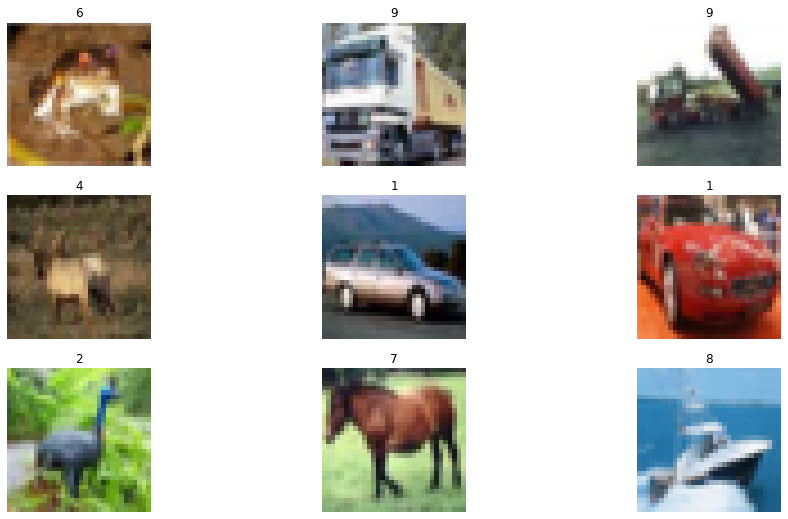

In [3]:
fig,axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16,9))
row_no = 0
col_no = 0
for i in range(9):
    axes[row_no][col_no].imshow(x_train[i])
    axes[row_no][col_no].axis('off')
    axes[row_no][col_no].set_title(y_train[i][0])
    if (col_no+1)%3 == 0:
        col_no = 0
        row_no += 1   
    else:
        col_no += 1
        
plt.show()

In [4]:
x_train.shape

(50000, 32, 32, 3)

<a id='2'></a>
## 2. Preprocessing Data

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train.ravel()))
train_ds = train_ds.map(lambda x,y: (tf.image.resize(x,(96,96)),y))
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test.ravel()))
test_ds = test_ds.map(lambda x,y: (tf.image.resize(x,(96,96)),y))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-07-23 13:18:40.529843: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
preprocess_layer = tf.keras.applications.vgg16.preprocess_input

preprocess_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet")
preprocess_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [7]:
input_layer = tf.keras.Input(shape = (96,96,3), name = 'input_layer')
x = preprocess_layer(input_layer)
output = preprocess_model(x)
preprocess_pipeline = tf.keras.Model(input_layer,output)

preprocess_pipeline.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
    optimizer  = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE)
)

In [8]:
#preprocessed_input = preprocess_pipeline.predict(train_ds)
#preprocessed_train_ds = tf.data.Dataset.from_tensor_slices((preprocessed_input, y_train.ravel()))
#tf.data.experimental.save(preprocessed_train_ds,"./")


# with open("./" + '/element_spec', 'wb') as out_: 
#    pickle.dump(preprocessed_train_ds.element_spec, out_)

# preprocessed_input = preprocess_pipeline.predict(test_ds)
# preprocessed_test_ds = tf.data.Dataset.from_tensor_slices((preprocessed_input, y_test.ravel()))
# tf.data.experimental.save(preprocessed_test_ds,"./")

In [9]:
# with open("/content/drive/MyDrive" + '/element_spec', 'rb') as in_:
#    es = pickle.load(in_)

# preprocessed_train_ds = tf.data.experimental.load(
#    "/content/drive/MyDrive", es
#)
# with open("/content/drive/MyDrive" + '/element_spec', 'rb') as in_:
#    es = pickle.load(in_)

# preprocessed_test_ds = tf.data.experimental.load(
#    "/content/drive/MyDrive", es
#)

In [10]:
# preprocessed_train_ds = preprocessed_train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# preprocessed_test_ds = preprocessed_test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

<a id='3'></a>
## 3. Default Model Performance

In [11]:
#inputs = layers.Input(shape = (3,3,512))
#x = layers.Flatten()(inputs)
#outputs = layers.Dense(10)(x)

#the_head = tf.keras.Model(inputs, outputs)
#the_head.compile(
#    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
#    metrics = ['accuracy'],
#    optimizer  = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE)
#)

# history_default = the_head.fit(preprocessed_train_ds,validation_data = preprocessed_test_ds, epochs = 30)

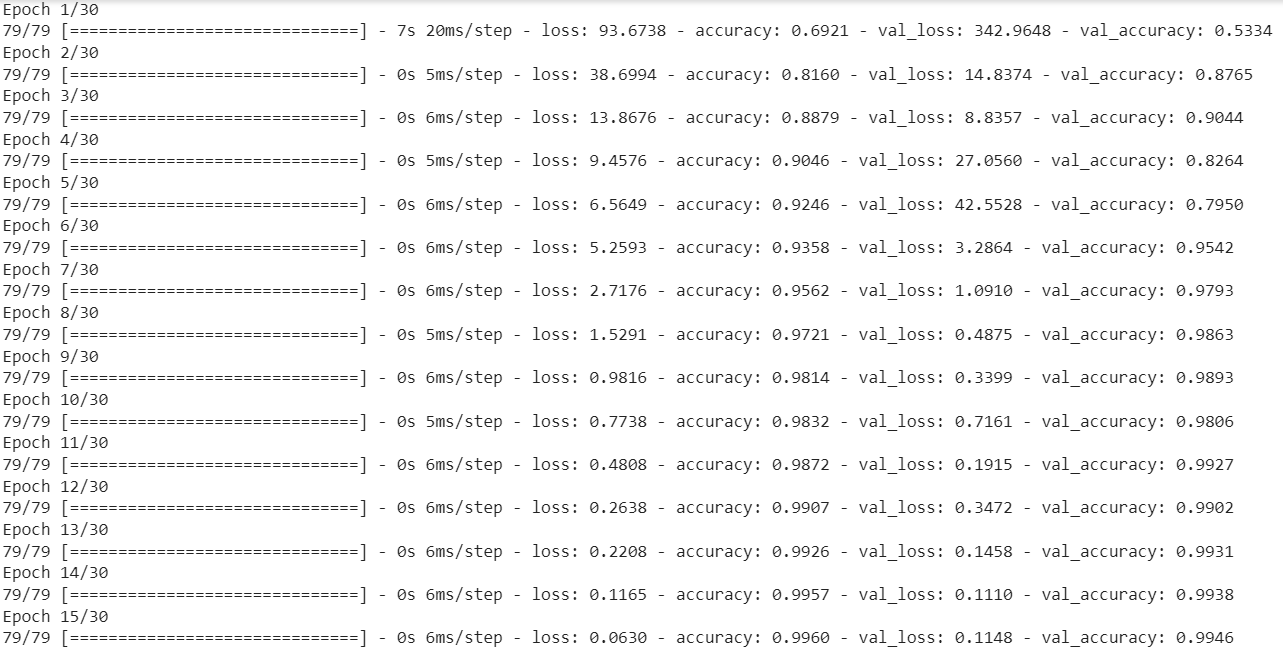
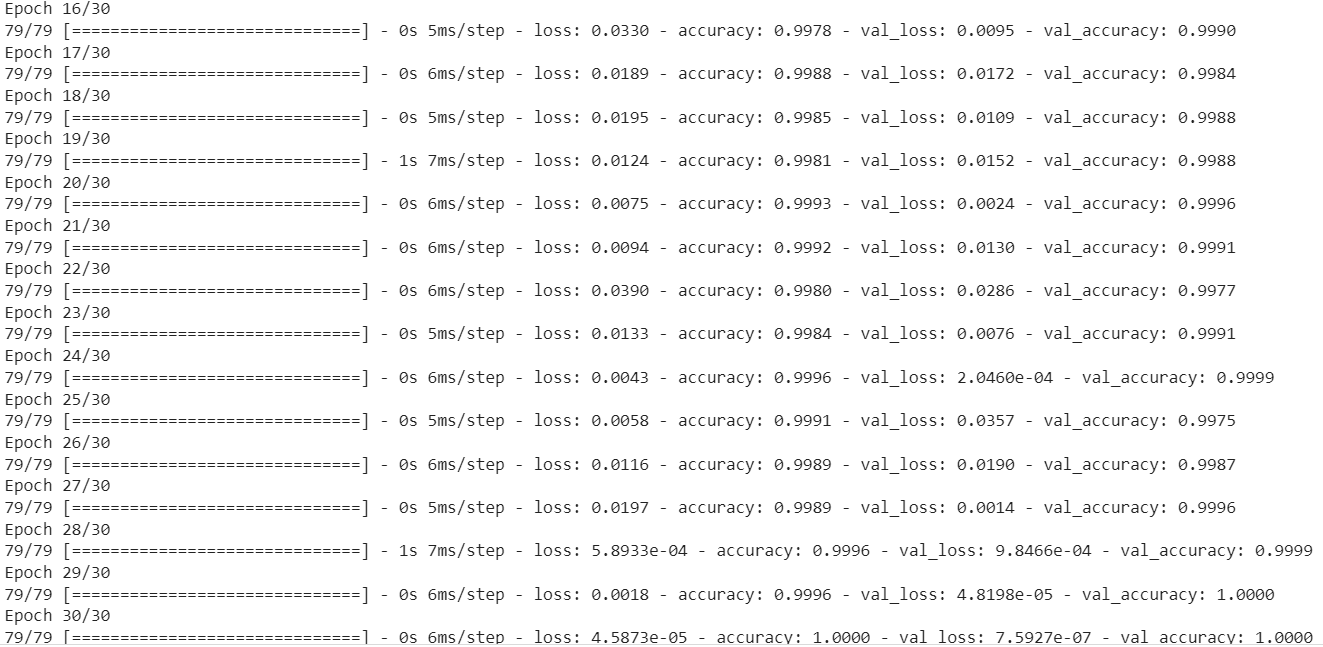

<a id='4'></a>
## 4. BatchNorm Model Performance

In [12]:
# inputs = layers.Input(shape = (3,3,512))
# x = layers.Flatten()(inputs)
# x = layers.Dense(10)(x)
# outputs = layers.BatchNormalization()(x)
# the_head_BN = tf.keras.Model(inputs, outputs)
# the_head_BN.compile(
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
#     metrics = ['accuracy'],
#     optimizer  = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE)
#)
# history_BN = the_head_BN.fit(preprocessed_train_ds,validation_data = preprocessed_test_ds, epochs = 30)

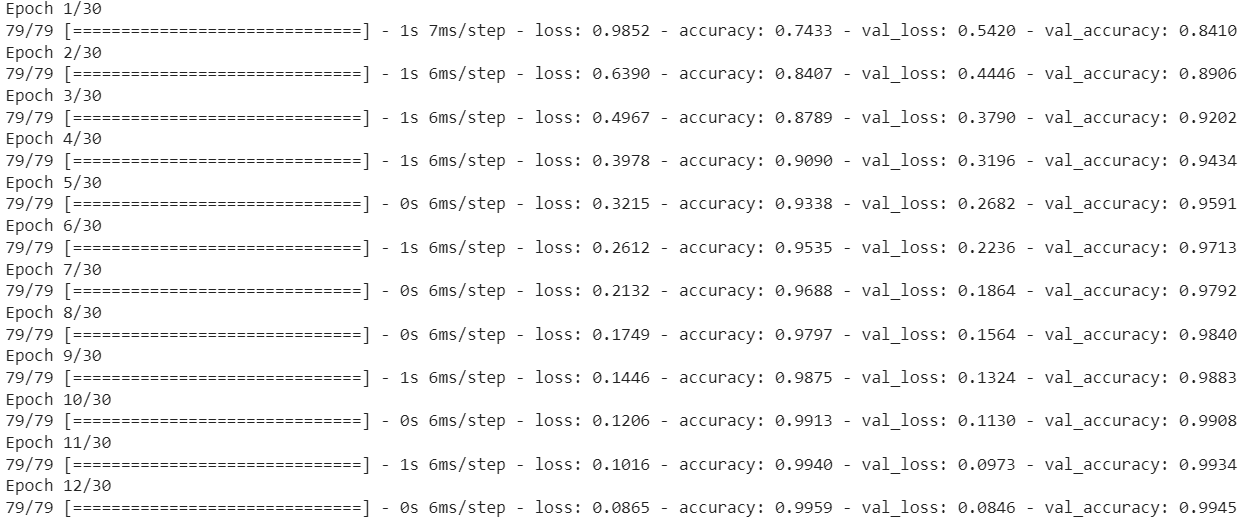
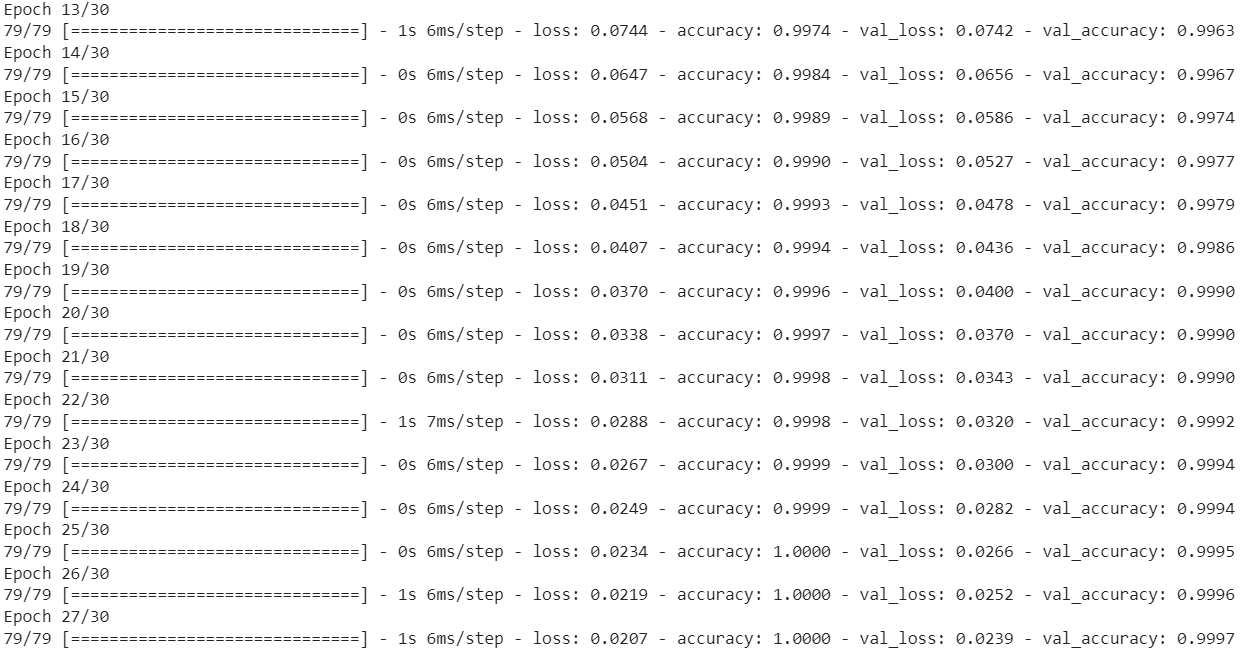
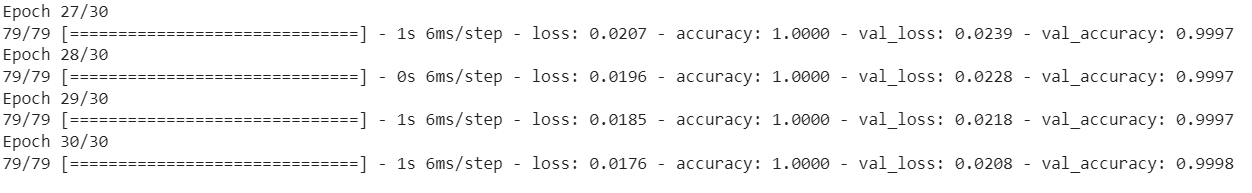

<a id='5'></a>
## 5. BatchNorm with Noise Model Performance

In [13]:
# inputs = layers.Input(shape = (3,3,512))
# x = layers.Flatten()(inputs)
# x = layers.Dense(10)(x)
# x = layers.BatchNormalization()(x)
# outputs = layers.GaussianNoise(1.25)(x)
# outputs = outputs + 0.5
# the_head_BN_noise = tf.keras.Model(inputs, outputs)
# the_head_BN_noise.compile(
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
#     metrics = ['accuracy'],
#     optimizer  = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE)
# )

# history_noise = the_head_BN_noise.fit(preprocessed_train_ds,epochs = 30,validation_data = preprocessed_test_ds)

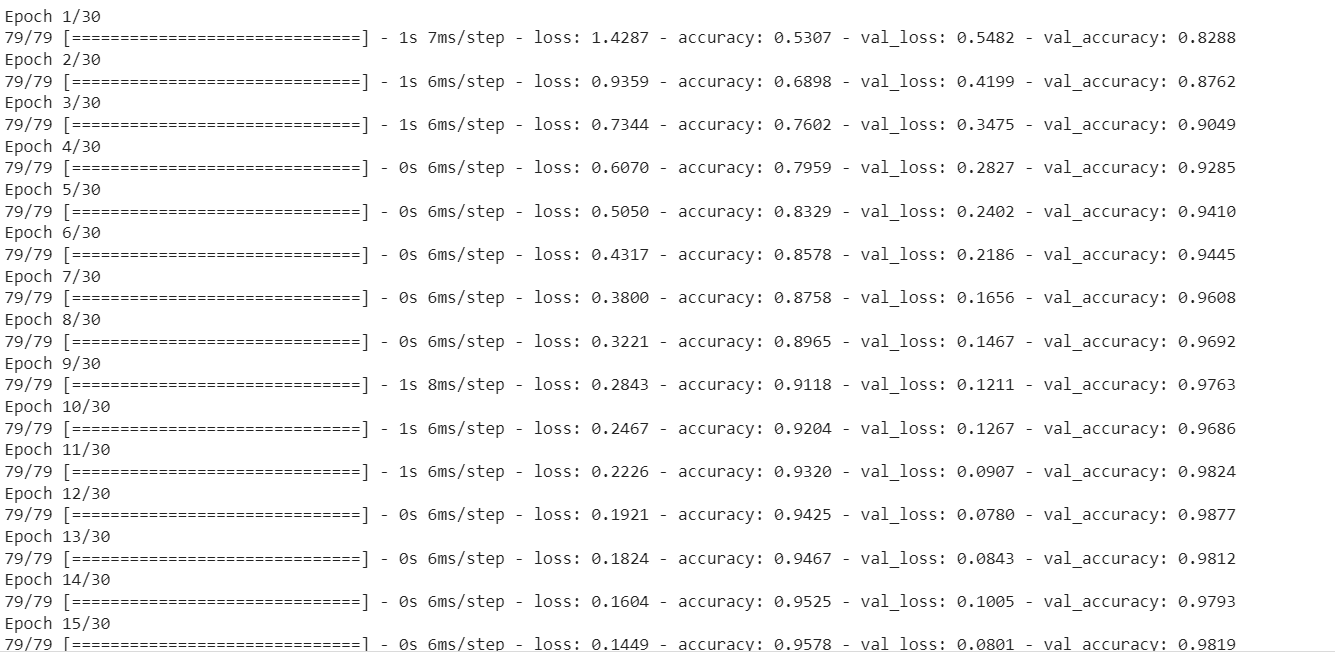
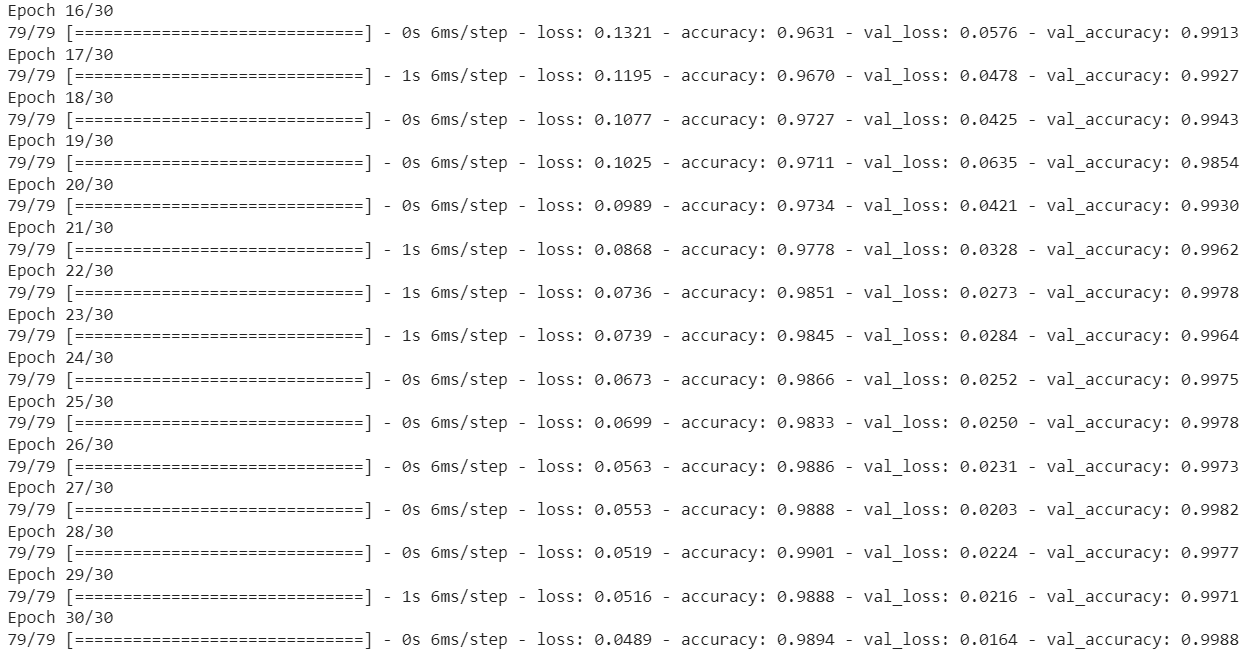

In [14]:
# num_epochs = list(range(30))
# default_results = np.array(history_default.history['val_accuracy'])*100
# BN_results = np.array(history_BN.history['val_accuracy'])*100
# noise_results = np.array(history_noise.history['val_accuracy'])*100

# plt.figure()
# plt.plot(num_epochs,default_results, label = 'Default Results')
# plt.plot(num_epochs,BN_results, label = 'BN Results')
# plt.plot(num_epochs,noise_results, label = 'Noise Results')
# plt.title('Model Comparison')
# plt.ylabel("Accuracy %")
# plt.xlabel("Epochs")
# plt.legend()
# plt.show()

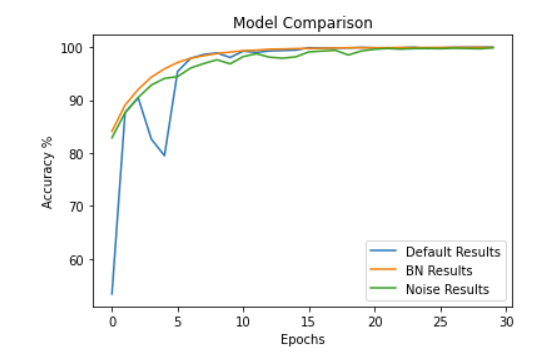

In [15]:
# num_epochs = list(range(30))
# default_results = np.array(history_default.history['val_loss'])
# BN_results = np.array(history_BN.history['val_loss'])

# plt.figure()
# plt.plot(num_epochs,default_results, label = 'Default Results')
# plt.plot(num_epochs,BN_results, label = 'BN Results')
# plt.title('Model Comparison')
# plt.ylabel("Loss")
# plt.xlabel("Epochs")
# plt.legend()
# plt.show()

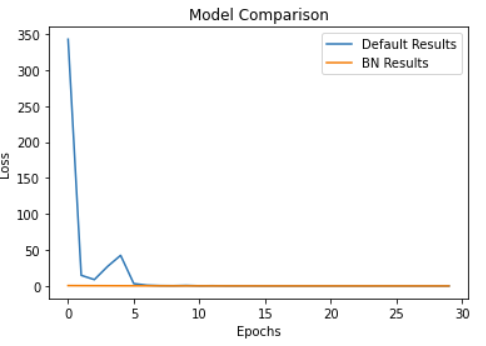